In [ ]:
# ref :  https://www.acceluniverse.com/blog/developers/2020/03/pythonefficientnet-multi-outpu.html

In [28]:
# organizing Dataset 
import os
import cv2 
import numpy as np
import matplotlib.pyplot as plt
import random 
import pandas as pd 


from IPython.display import clear_output

%matplotlib inline

In [29]:
train_df = pd.read_csv("fairface_label_train.csv") # shape is (86744, 5)
test_df = pd.read_csv("fairface_label_val.csv") # shape is (10954, 5) 

In [30]:
train_df

file           age  gender        race  service_test
0          train/1.jpg         50-59    Male  East Asian          True
1          train/2.jpg         30-39  Female      Indian         False
2          train/3.jpg           3-9  Female       Black         False
3          train/4.jpg         20-29  Female      Indian          True
4          train/5.jpg         20-29  Female      Indian          True
...                ...           ...     ...         ...           ...
86739  train/86740.jpg         20-29    Male      Indian          True
86740  train/86741.jpg         10-19    Male      Indian          True
86741  train/86742.jpg  more than 70  Female      Indian          True
86742  train/86743.jpg         10-19  Female       Black          True
86743  train/86744.jpg         40-49    Male       White         False

[86744 rows x 5 columns]

In [31]:
train_df["age_id"] = train_df["age"].astype("category").cat.codes
train_df["race_id"] = train_df["race"].astype("category").cat.codes
train_df["gender_id"] = train_df["gender"].astype("category").cat.codes


In [32]:
race_c = train_df["race"].astype("category").astype("category")
d_race = dict(enumerate(race_c.cat.categories))
d_race


{0: 'Black',
 1: 'East Asian',
 2: 'Indian',
 3: 'Latino_Hispanic',
 4: 'Middle Eastern',
 5: 'Southeast Asian',
 6: 'White'}

In [33]:
gender_c = train_df["gender"].astype("category").astype("category")
d_gender = dict(enumerate(gender_c.cat.categories))
d_gender


{0: 'Female', 1: 'Male'}

In [34]:
age_c = train_df["age"].astype("category").astype("category")
d_age = dict(enumerate(age_c.cat.categories))
print(age_c)


0               50-59
1               30-39
2                 3-9
3               20-29
4               20-29
             ...     
86739           20-29
86740           10-19
86741    more than 70
86742           10-19
86743           40-49
Name: age, Length: 86744, dtype: category
Categories (9, object): ['0-2', '10-19', '20-29', '3-9', ..., '40-49', '50-59', '60-69', 'more than 70']


In [35]:
train_df

file           age  gender        race  service_test  \
0          train/1.jpg         50-59    Male  East Asian          True   
1          train/2.jpg         30-39  Female      Indian         False   
2          train/3.jpg           3-9  Female       Black         False   
3          train/4.jpg         20-29  Female      Indian          True   
4          train/5.jpg         20-29  Female      Indian          True   
...                ...           ...     ...         ...           ...   
86739  train/86740.jpg         20-29    Male      Indian          True   
86740  train/86741.jpg         10-19    Male      Indian          True   
86741  train/86742.jpg  more than 70  Female      Indian          True   
86742  train/86743.jpg         10-19  Female       Black          True   
86743  train/86744.jpg         40-49    Male       White         False   

       age_id  race_id  gender_id  
0           6        1          1  
1           4        2          0  
2           3        0          0  
3           2        2          0  
4           2        2          0  
...       ...      ...        ...  
86739       2        2          1  
86740       1        2          1  
86741       8        2          0  
86742       1        0          0  
86743       5        6          1  

[86744 rows x 8 columns]

<AxesSubplot:>

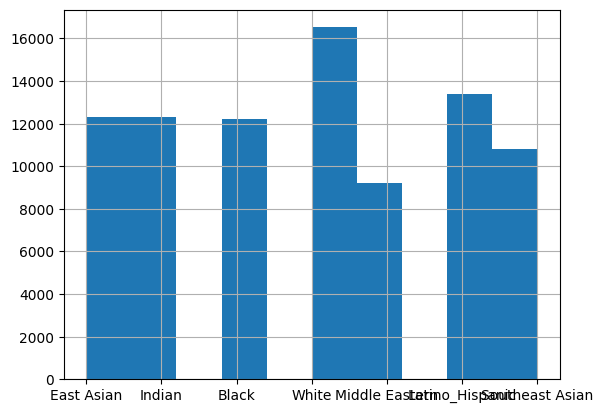

In [36]:
train_df["race"].hist()

<AxesSubplot:>

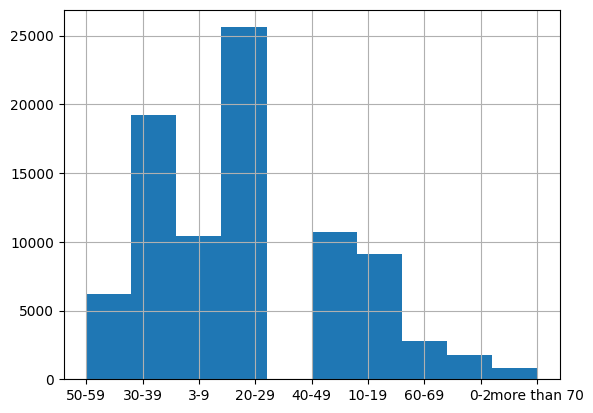

In [37]:
train_df["age"].hist()

<AxesSubplot:>

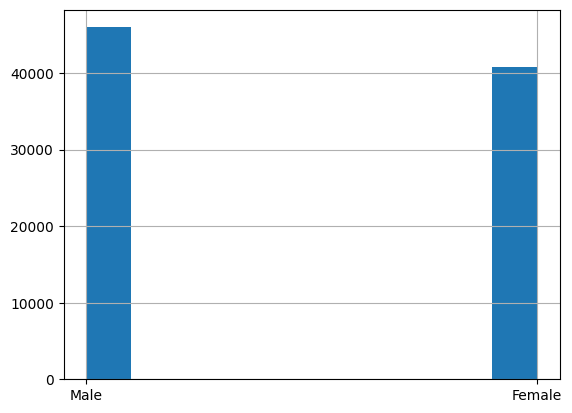

In [38]:
train_df["gender"].hist()

# 学習コード

In [23]:
import glob
import math
import os
import random

import cv2
import numpy as np
import pandas as pd
import scipy
from matplotlib import pyplot as plt
from PIL import Image
from scipy.stats import multivariate_normal
from skimage import io
from sklearn.model_selection import train_test_split
from tqdm import tqdm

import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2, ResNet50
from tensorflow.keras.layers import (
    Activation,
    AveragePooling2D,
    MaxPooling2D,
    BatchNormalization,
    Concatenate,
    Conv2D,
    Conv2DTranspose,
    Dense,
    Dropout,
    Flatten,
    GlobalAveragePooling2D,
    Input,
    MaxPool2D,
    Reshape,
    UpSampling2D,
    concatenate,
)
from tensorflow.keras.applications import EfficientNetB0

from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam

# import tensorflow_addons as tfa
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [45]:
seed = 42
NUM_CLASSES_GENDER=2
NUM_CLASSES_RACE=7
NUM_CLASSES_AGE=9
EPOCHS=30
INPUT_SIZE = (224, 224)
BATCH_SIZE = 16
out_root = "./results/"

In [35]:
from datetime import datetime, timezone, timedelta

tz_jst = timezone(timedelta(hours=9))
train_start_time = datetime.now(tz=tz_jst).strftime('%Y%m%d_%H%M')

out_root = out_root + train_start_time +  "/"

In [25]:
X_paths = train_df["file"].values.tolist()
y = train_df["race"].values.tolist()

In [26]:
X_train, X_val, y_train, y_val = train_test_split(
    X_paths, y, test_size=0.2, random_state=seed
)

In [39]:
train_df["is_train"] = train_df['file'].isin(X_train)

In [32]:
info = {}
info["num_classes_gender"] = NUM_CLASSES_GENDER
info["num_classes_race"] = NUM_CLASSES_RACE
info["num_classes_age"] = NUM_CLASSES_AGE
info["input_shape"] = INPUT_SIZE
info["batch_size"] = BATCH_SIZE

In [36]:
import albumentations as A

transform = A.Compose(
    [
        A.HorizontalFlip(p=0.5),
        A.RandomBrightnessContrast(
            brightness_limit=(-0.1, 0.1), contrast_limit=(-0.1, 0.1), p=0.5
        ),
        A.ShiftScaleRotate(p=0.5, shift_limit=0.0625, rotate_limit=(-5, 5)),
        A.RandomResizedCrop(
            width=info["input_shape"][1],
            height=info["input_shape"][0],
            scale=(0.9, 1.1),
        ),
    ]
)

In [98]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(
        self, df, subset="train", shuffle=False, preprocess=None, info={}
    ):
        super().__init__()
        self.paths = df["file"].values
        self.labels_age = df["age_id"].values
        self.labels_race = df["race_id"].values
        self.labels_gender = df["gender_id"].values

        self.subset = subset
        self.shuffle = shuffle
        self.preprocess = preprocess
        self.info = info
        self.num_class_gender = info["num_classes_gender"] 
        self.num_class_race = info["num_classes_race"] 
        self.num_class_age = info["num_classes_age"] 
        self.input_shape = info["input_shape"]
        self.batch_size = info["batch_size"]
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.paths) / self.batch_size))

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.paths))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __getitem__(self, index):

        X = np.empty(
            (self.batch_size, self.input_shape[0], self.input_shape[1], 3),
            dtype=np.float32,
        )
        y_age = np.zeros((self.batch_size, self.num_class_age), dtype=np.uint8)
        y_race = np.zeros((self.batch_size, self.num_class_race), dtype=np.uint8)
        y_gender = np.zeros((self.batch_size, self.num_class_gender), dtype=np.uint8)
        indexes = self.indexes[index * self.batch_size : (index + 1) * self.batch_size]
        
        
        for i, idx in enumerate(indexes):
            # images
            img_path = self.paths[idx]
            image = (np.array(Image.open(img_path).convert("RGB")) / 255).astype(
                np.float32
            )
            if len(image.shape) == 2:
                image = np.stack([image, image, image], 2)
            
            # labels
            y_age[i, self.labels_age[idx]] = 1
            y_race[i, self.labels_race[idx]] = 1
            y_gender[i, self.labels_gender[idx]] = 1

            # ================================
            # preprocessing with albumentations
            # ================================
            if self.preprocess != None:
                transformed = self.preprocess(image=image)
                X[i,] = transformed[
                    "image"
                ].astype(np.float32)
            else:
                X[i,] = cv2.resize(
                    image,
                    dsize=(self.input_shape[1], self.input_shape[0]),
                    interpolation=cv2.INTER_CUBIC,
                ).astype(np.float32)

        
        # ================================
        # return
        # ================================
        return X.astype(np.float32), [y_age.astype(np.float32), y_race.astype(np.float32), y_gender.astype(np.float32)]

In [99]:
train_datagenerator = DataGenerator(
    train_df[train_df["is_train"]], subset="train", shuffle=True, preprocess=transform, info=info
)

valid_datagenerator = DataGenerator(
    train_df[~train_df["is_train"]], subset="valid", shuffle=False, preprocess=None, info=info
)

In [100]:
train_datagenerator[0][1][0].shape

(16, 9)

In [101]:
def myMobileNetV2(n_classes, input_size=(224, 224, 3)):
    """Input"""
    inputs = Input(input_size)

    """ Encoder """
    # model = EfficientNetB0(weights='imagenet')
    
    encoder = MobileNetV2(weights="imagenet", include_top=False, input_tensor=inputs)
    h = Flatten()(encoder.output)
    model_output_age = Dense(n_classes[0], activation="softmax", name='age_output')(h)
    model_output_race = Dense(n_classes[1], activation="softmax", name='race_output')(h)
    model_output_gender = Dense(n_classes[2], activation="softmax", name='gender_output')(h)

    model = Model(inputs, [model_output_age, model_output_race, model_output_gender])
    return model

In [104]:
model = myMobileNetV2(n_classes=[ NUM_CLASSES_AGE, NUM_CLASSES_RACE, NUM_CLASSES_GENDER])
steps_per_epoch = np.ceil((len(X_train)) / BATCH_SIZE)
steps_per_epoch_val = np.ceil((len(X_val)) / BATCH_SIZE)

if True:
    es = tf.keras.callbacks.EarlyStopping(
        monitor="val_accuracy", mode="max", verbose=1, patience=10
    )  # Early stopping (stops training when validation doesn't improve for {patience} epochs)
    save_best = tf.keras.callbacks.ModelCheckpoint(
        f"{out_root}myMobileNetV2.h5", monitor="val_race_output_accuracy", save_best_only=True, mode="max"
    )  # Saves the best version of the model to disk (as measured on the validation data set)
    learning_rate_reduction = tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_race_output_accuracy", patience=2, verbose=1, factor=0.1
    )

    # Warming up
    model.compile(optimizer=SGD(learning_rate=1e-4), 
              loss={'age_output': 'categorical_crossentropy', 'race_output': 'categorical_crossentropy', 'gender_output': 'categorical_crossentropy'},
              metrics={'age_output': 'accuracy', 'race_output': 'accuracy', 'gender_output': 'accuracy'})


    history = model.fit_generator(
        train_datagenerator,
        epochs=EPOCHS,
        validation_data=valid_datagenerator,
        callbacks=[es, save_best, learning_rate_reduction],
    )

    # summarize history for loss
    plt.plot(history.history["loss"])
    plt.plot(history.history["val_loss"])
    plt.title("model loss")
    plt.ylabel("loss")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.savefig(f"{out_root}loss.jpg")
    plt.show()
    model.load_weights(f"{out_root}myMobileNetV2.h5")
    model.save(f"{out_root}myMobileNetV2_save.h5", include_optimizer=False)
else:
    model.load_weights(f"{out_root}myMobileNetV2.h5")
    # model.evaluate(val_datagen, verbose=1)

Epoch 1/30
4337/4337 [==============================] - 329s 75ms/step - loss: 4.5043 - age_output_loss: 1.9243 - race_output_loss: 1.9254 - gender_output_loss: 0.6546 - age_output_accuracy: 0.3060 - race_output_accuracy: 0.3096 - gender_output_accuracy: 0.6833 - val_loss: 3.8839 - val_age_output_loss: 1.6778 - val_race_output_loss: 1.6647 - val_gender_output_loss: 0.5415 - val_age_output_accuracy: 0.3536 - val_race_output_accuracy: 0.3759 - val_gender_output_accuracy: 0.7422


/usr/local/lib/python3.8/dist-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/30
4337/4337 [==============================] - 324s 75ms/step - loss: 3.6459 - age_output_loss: 1.5838 - race_output_loss: 1.5616 - gender_output_loss: 0.5005 - age_output_accuracy: 0.3695 - race_output_accuracy: 0.4037 - gender_output_accuracy: 0.7547 - val_loss: 3.4604 - val_age_output_loss: 1.5133 - val_race_output_loss: 1.4861 - val_gender_output_loss: 0.4610 - val_age_output_accuracy: 0.3948 - val_race_output_accuracy: 0.4331 - val_gender_output_accuracy: 0.7784
Epoch 3/30
4337/4337 [==============================] - 324s 75ms/step - loss: 3.3587 - age_output_loss: 1.4758 - race_output_loss: 1.4394 - gender_output_loss: 0.4435 - age_output_accuracy: 0.3995 - race_output_accuracy: 0.4497 - gender_output_accuracy: 0.7858 - val_loss: 3.2242 - val_age_output_loss: 1.4292 - val_race_output_loss: 1.3823 - val_gender_output_loss: 0.4127 - val_age_output_accuracy: 0.4137 - val_race_output_accuracy: 0.4727 - val_gender_output_accuracy: 0.8040
Epoch 4/30
4337/4337 [================

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



# 評価

In [106]:
from tensorflow import keras
keras.backend.clear_session() 

In [107]:
from tensorflow.python.keras.models import load_model
# del model
reconstructed_model  = load_model(f"{out_root}myMobileNetV2_save.h5", compile=False)

In [110]:
info = {}
info["num_classes_gender"] = NUM_CLASSES_GENDER
info["num_classes_race"] = NUM_CLASSES_RACE
info["num_classes_age"] = NUM_CLASSES_AGE
info["input_shape"] = INPUT_SIZE
info["batch_size"] = 1

valid_datagenerator = DataGenerator(
    train_df[~train_df["is_train"]], subset="valid", shuffle=False, preprocess=None, info=info
)

preds_all_0 = []
true_all_0 = []
preds_all_1 = []
true_all_1 = []
preds_all_2 = []
true_all_2 = []

for idx, data in enumerate(tqdm(valid_datagenerator)):
    img = data[0]
    lbl = data[1]
    # print(data[0].shape)
    preds = reconstructed_model.predict(img)
    
    
    pred_cls_0 = tf.argmax(preds[0], axis=-1).numpy()[0]
    lbl_cls_0 = tf.argmax(lbl[0], axis=-1).numpy()[0]
    pred_cls_1 = tf.argmax(preds[1], axis=-1).numpy()[0]
    lbl_cls_1 = tf.argmax(lbl[1], axis=-1).numpy()[0]
    pred_cls_2 = tf.argmax(preds[2], axis=-1).numpy()[0]
    lbl_cls_2 = tf.argmax(lbl[2], axis=-1).numpy()[0]   
    
    # if pred_cls!=lbl_cls:
    #     print("True:",dict_cls[lbl_cls[0]], "pred:",dict_cls[pred_cls])
    #     plt.imshow(img[0,:,:,:])
    #     plt.show()
    
    preds_all_0.append(pred_cls_0)
    true_all_0.append(lbl_cls_0)
    preds_all_1.append(pred_cls_1)
    true_all_1.append(lbl_cls_1)
    preds_all_2.append(pred_cls_2)
    true_all_2.append(lbl_cls_2)
    
    # plt.imshow(img[0, :, :, :])
    # plt.title(f"pred:{d[pred_cls[0]]}, true:{d[lbl_cls[0]]}")
    # plt.show()
    # if idx > 20:
    #     break

preds_all_0 = np.array(preds_all_0)
true_all_0 = np.array(true_all_0)
preds_all_1 = np.array(preds_all_1)
true_all_1 = np.array(true_all_1)
preds_all_2 = np.array(preds_all_2)
true_all_2 = np.array(true_all_2)

100%|██████████| 17349/17349 [15:47<00:00, 18.32it/s]


# 可視化

In [114]:
from sklearn.metrics import classification_report, confusion_matrix

age  = list(d_age.values())
race = list(d_race.values())
gender = list(d_gender.values())

In [115]:
def plot_confusion_matrix(cm, classes, 
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in zip(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


In [116]:
plt.rcParams['figure.figsize'] = (16.0, 6.0)

              precision    recall  f1-score   support

         0-2       0.73      0.70      0.72       377
       10-19       0.45      0.37      0.40      1768
       20-29       0.56      0.66      0.60      5174
         3-9       0.74      0.74      0.74      2045
       30-39       0.44      0.41      0.43      3903
       40-49       0.38      0.36      0.37      2094
       50-59       0.40      0.35      0.37      1264
       60-69       0.40      0.37      0.39       556
more than 70       0.39      0.36      0.37       168

    accuracy                           0.51     17349
   macro avg       0.50      0.48      0.49     17349
weighted avg       0.51      0.51      0.51     17349

Normalized confusion matrix
[[7.02917772e-01 5.30503979e-03 1.32625995e-02 2.73209549e-01
  5.30503979e-03 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [0.00000000e+00 3.65950226e-01 3.93665158e-01 1.71380090e-01
  5.37330317e-02 1.01809955e-02 3.39366516e-03 5.65610860e-04
 

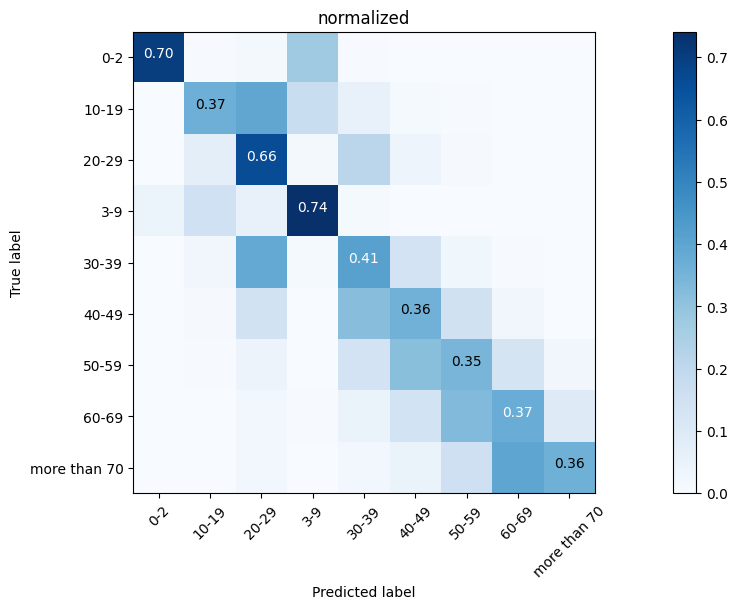

In [117]:
print(classification_report(true_all_0, preds_all_0, target_names=age))

# confusion matrixの作成
cnf_matrix=confusion_matrix(true_all_0, preds_all_0)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=age,  normalize=True, title="normalized")
plt.show()

                 precision    recall  f1-score   support

          Black       0.76      0.80      0.78      2427
     East Asian       0.66      0.72      0.69      2439
         Indian       0.67      0.66      0.66      2451
Latino_Hispanic       0.48      0.44      0.46      2727
 Middle Eastern       0.52      0.48      0.50      1840
Southeast Asian       0.56      0.54      0.55      2073
          White       0.66      0.69      0.68      3392

       accuracy                           0.62     17349
      macro avg       0.62      0.62      0.62     17349
   weighted avg       0.62      0.62      0.62     17349

Normalized confusion matrix
[[0.80304903 0.00988875 0.06674907 0.05850845 0.00865266 0.03255047
  0.02060157]
 [0.01148011 0.71627716 0.00820008 0.03321033 0.01066011 0.1697417
  0.0504305 ]
 [0.08853529 0.01142391 0.65932273 0.1126071  0.05752754 0.03671971
  0.03386373]
 [0.06087275 0.04510451 0.11404474 0.43894389 0.09974331 0.08214155
  0.15914925]
 [0.02445652 0.

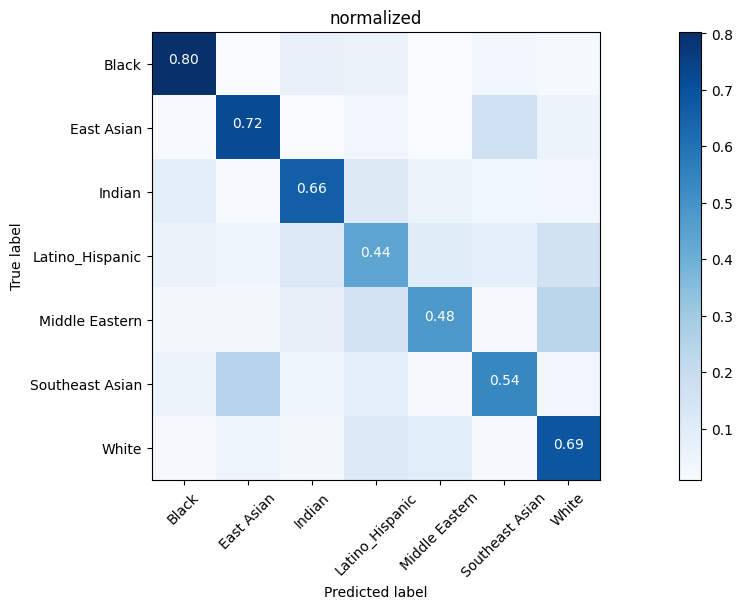

In [118]:
print(classification_report(true_all_1, preds_all_1, target_names=race))

# confusion matrixの作成
cnf_matrix=confusion_matrix(true_all_1, preds_all_1)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=race,  normalize=True, title="normalized")
plt.show()

              precision    recall  f1-score   support

      Female       0.89      0.89      0.89      8105
        Male       0.90      0.90      0.90      9244

    accuracy                           0.89     17349
   macro avg       0.89      0.89      0.89     17349
weighted avg       0.89      0.89      0.89     17349

Normalized confusion matrix
[[0.88908081 0.11091919]
 [0.10038944 0.89961056]]


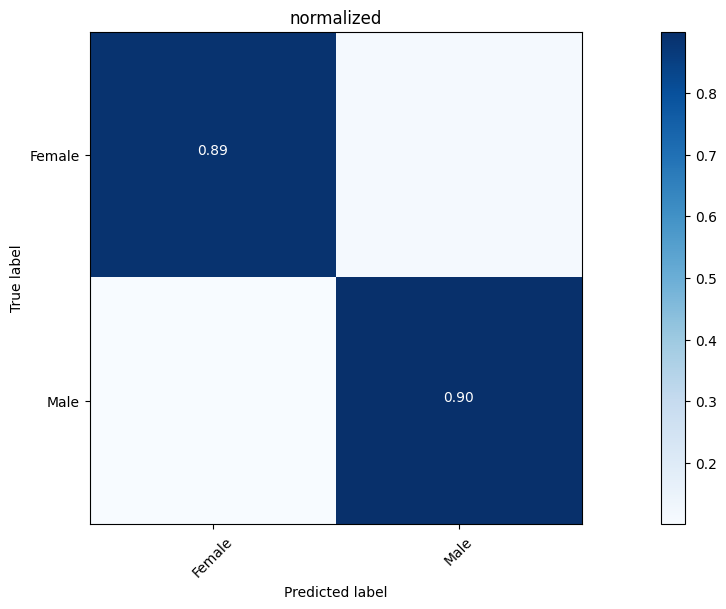

In [119]:
print(classification_report(true_all_2, preds_all_2, target_names=gender))

# confusion matrixの作成
cnf_matrix=confusion_matrix(true_all_2, preds_all_2)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=gender,  normalize=True, title="normalized")
plt.show()

  0%|          | 0/17349 [00:00<?, ?it/s]

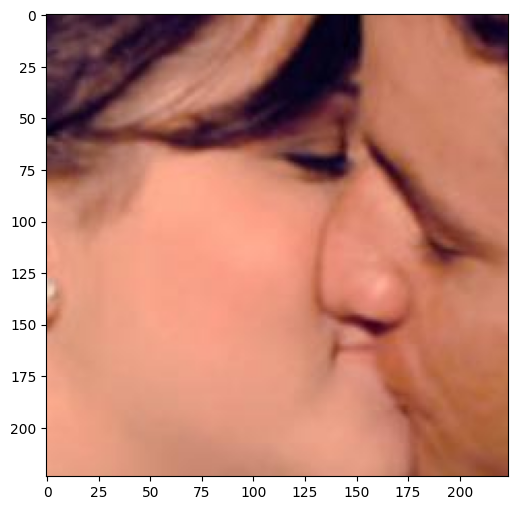

  0%|          | 1/17349 [00:00<57:05,  5.06it/s]

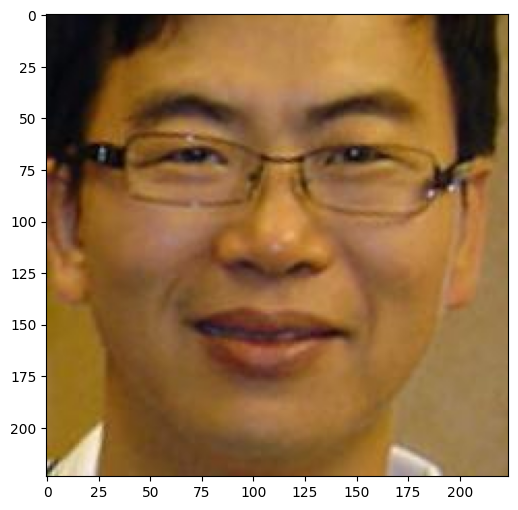

  0%|          | 2/17349 [00:00<56:56,  5.08it/s]

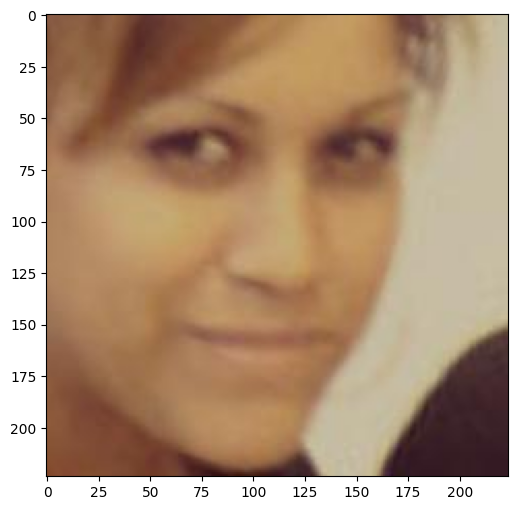

  0%|          | 3/17349 [00:00<56:11,  5.14it/s]

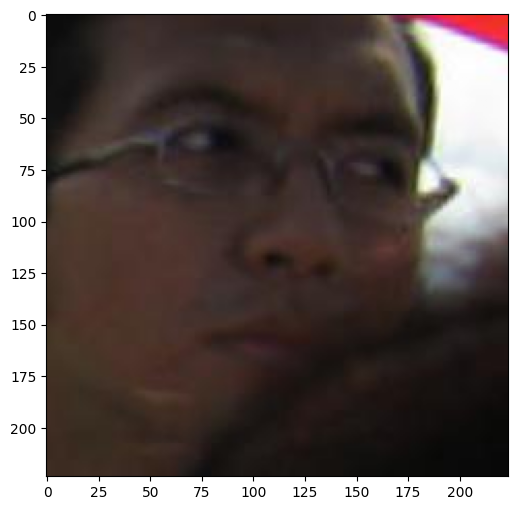

  0%|          | 4/17349 [00:00<52:37,  5.49it/s]

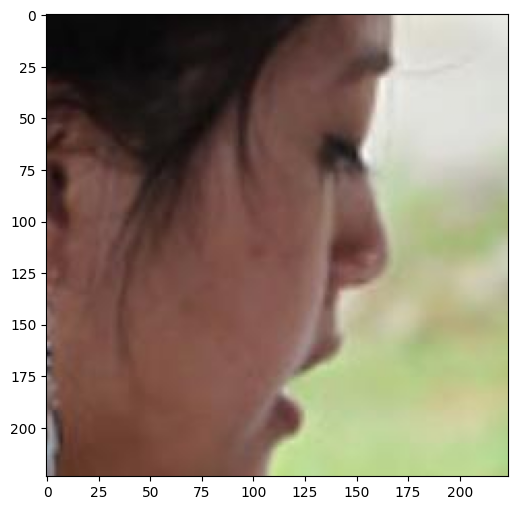

  0%|          | 5/17349 [00:00<52:28,  5.51it/s]

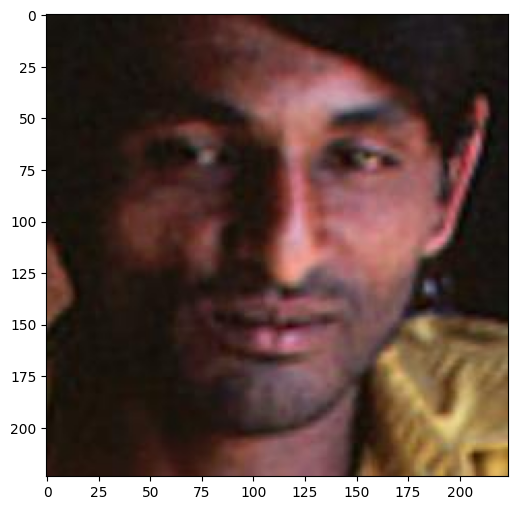

  0%|          | 6/17349 [00:01<53:18,  5.42it/s]

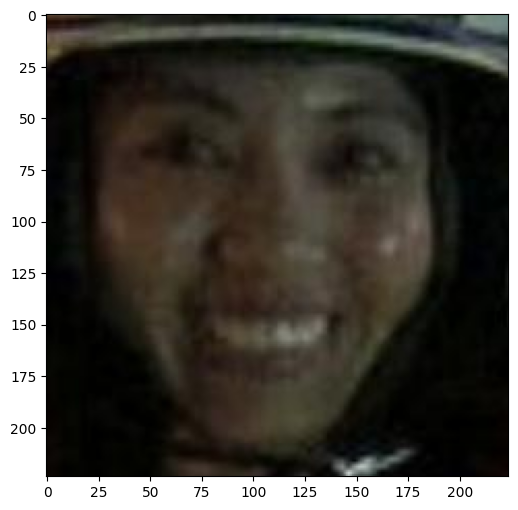

  0%|          | 7/17349 [00:01<52:25,  5.51it/s]

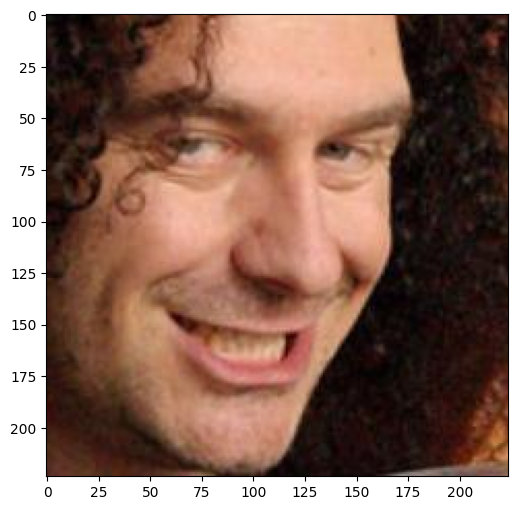

  0%|          | 8/17349 [00:01<54:35,  5.29it/s]

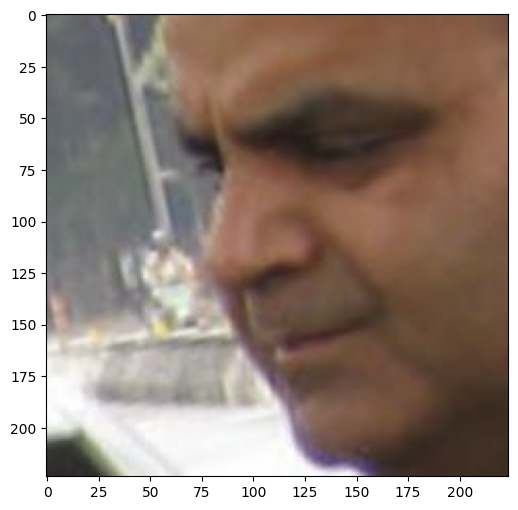

  0%|          | 9/17349 [00:01<54:15,  5.33it/s]

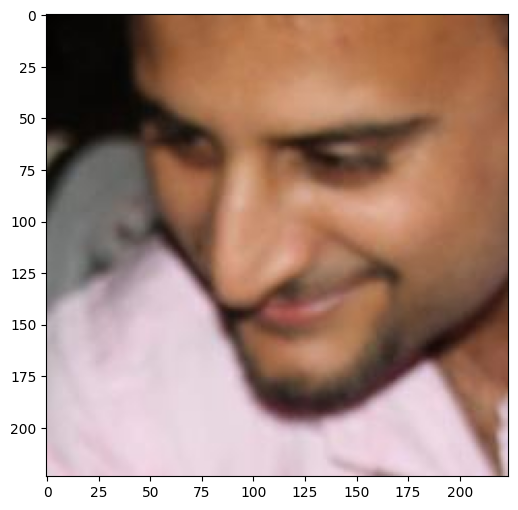

  0%|          | 10/17349 [00:01<53:37,  5.39it/s]

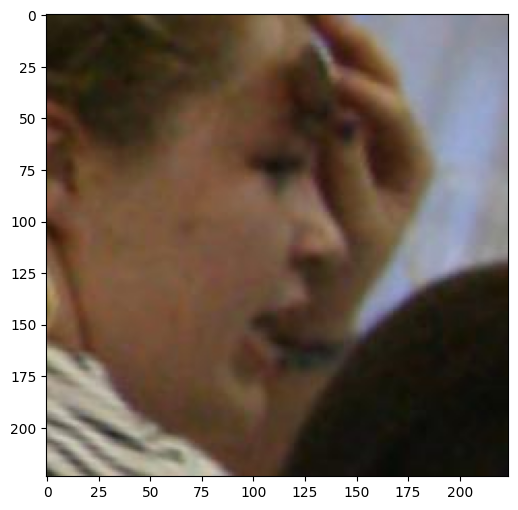

  0%|          | 11/17349 [00:02<53:38,  5.39it/s]

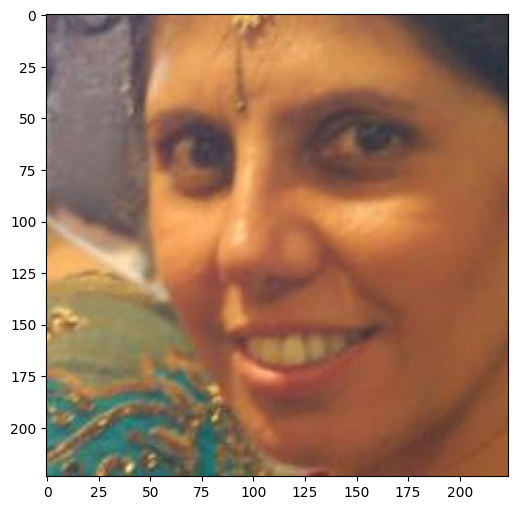

  0%|          | 12/17349 [00:02<54:48,  5.27it/s]

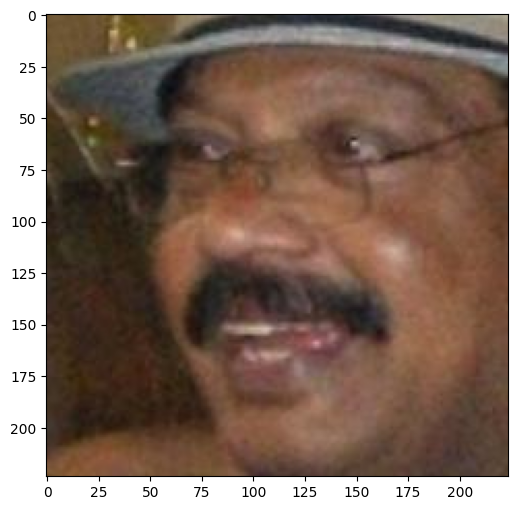

  0%|          | 13/17349 [00:02<55:56,  5.16it/s]

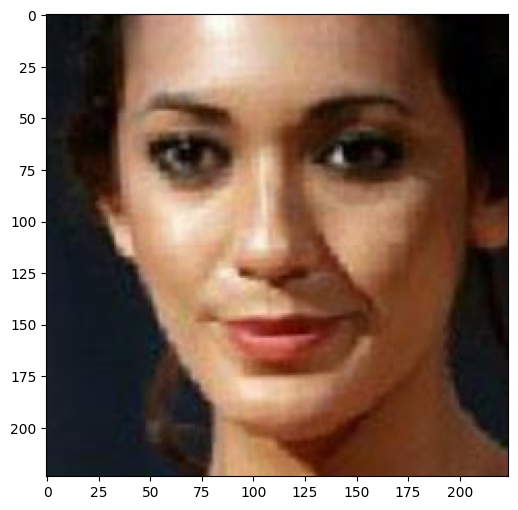

  0%|          | 14/17349 [00:02<56:34,  5.11it/s]

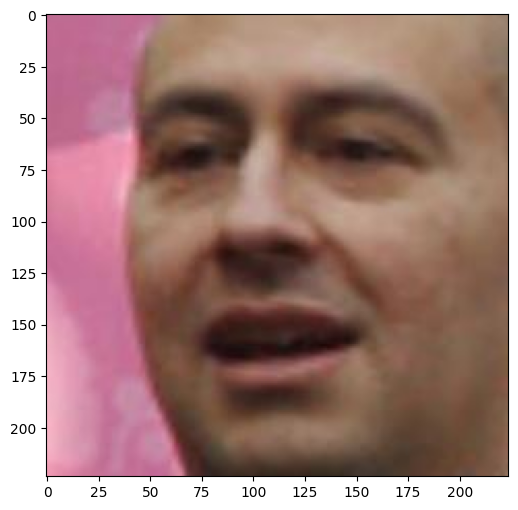

  0%|          | 15/17349 [00:02<56:26,  5.12it/s]

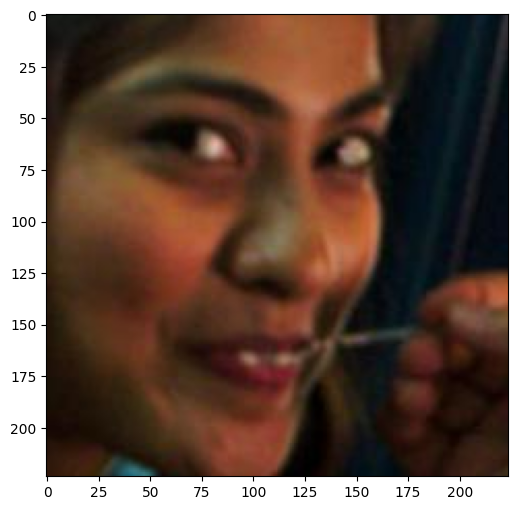

  0%|          | 16/17349 [00:03<58:16,  4.96it/s]

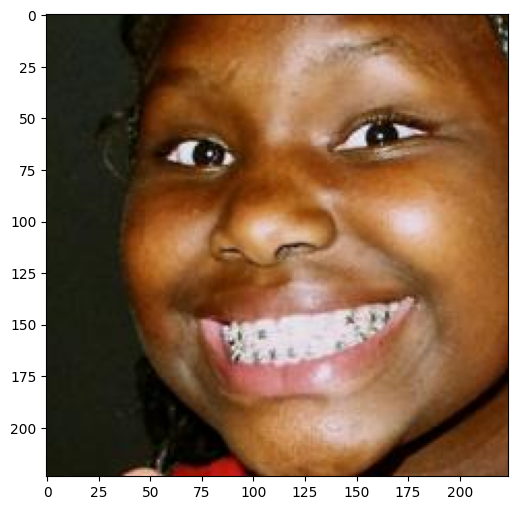

  0%|          | 17/17349 [00:03<59:22,  4.87it/s]

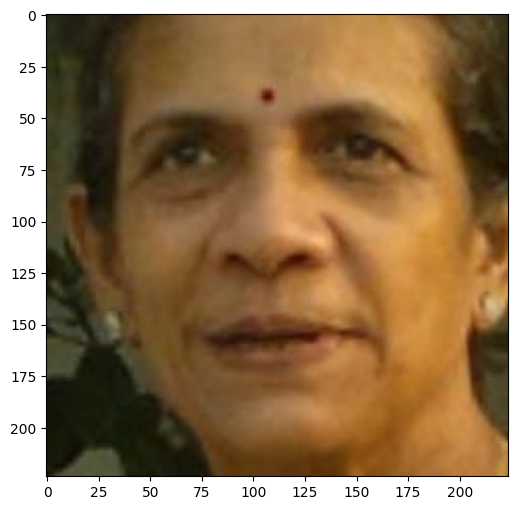

  0%|          | 18/17349 [00:03<58:01,  4.98it/s]

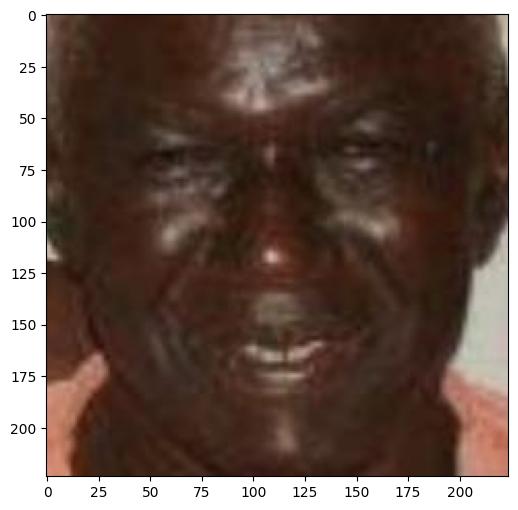

  0%|          | 19/17349 [00:03<55:44,  5.18it/s]

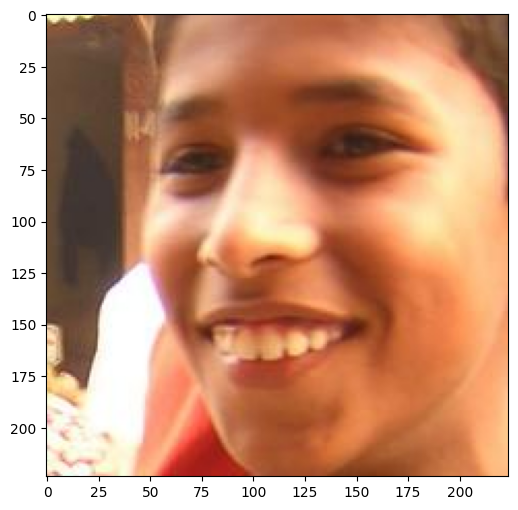

  0%|          | 20/17349 [00:03<55:45,  5.18it/s]

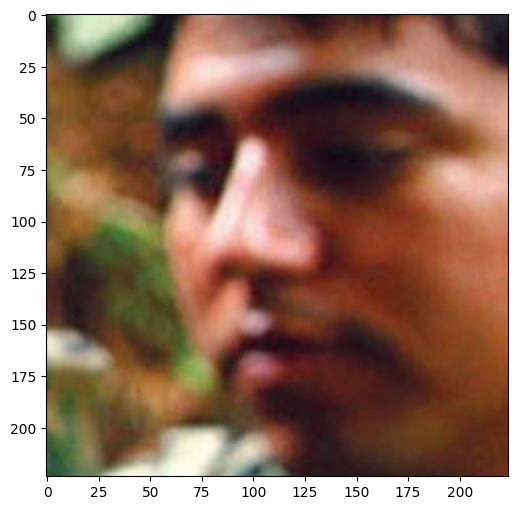

  0%|          | 21/17349 [00:04<56:03,  5.15it/s]

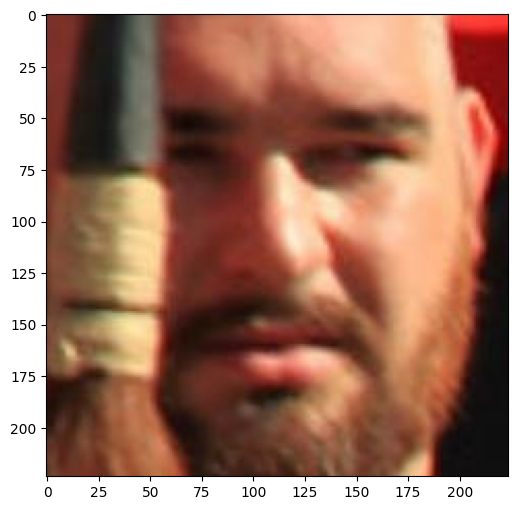

  0%|          | 21/17349 [00:04<58:30,  4.94it/s]


In [121]:

for idx, data in enumerate(tqdm(valid_datagenerator)):
    img = data[0]

    plt.imshow(img[0, :, :, :])
    plt.show()
    if idx > 20:
        break